In [ ]:
import torch

import sys
from pathlib import Path
import os
assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))


from src.evaluation.evaluate import evaluate_and_plot, evaluate_benchmark
from src.methods.fewshot.sampling import sample_k_per_class, sample_fewshot_task
from src.methods.fewshot.prototypical import compute_prototypes, classify
from transformers import HubertModel
from src.datasets.bird_dog_cat import AnimalAudioDataset
from src.methods.fewshot.benchmark import benchmark_fewshot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
root_dir = "Animals"

dataset = AnimalAudioDataset(root_dir)

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))


Classes : ['bird', 'cat', 'dog']
Nombre total de fichiers : 610


In [16]:
X = []
y = []

for waveform, label in dataset:
    X.append(waveform)
    y.append(label)

X = torch.stack(X)      
y = torch.tensor(y)     


print(X.shape)  
print(y.shape)  


torch.Size([610, 16000])
torch.Size([610])


In [4]:
X_support, y_support, X_query, y_query = sample_k_per_class(
    X, y, k=1
)

In [6]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

In [27]:
prototypes, proto_labels = compute_prototypes(
    hubert, X_support, y_support
)

preds = classify(
    hubert, X_query, prototypes, proto_labels
)

acc = (preds.cpu() == y_query).float().mean()
print("Few-shot accuracy:", acc.item())


Few-shot accuracy: 0.780889630317688


## Benchmark

In [19]:
results = {}
for k in [1,5,10]:
    results[k] = benchmark_fewshot(model=hubert, X=X, y=y, device=device, k_shot=k, n_tasks=10)


10-shot benchmark: 100%|██████████| 10/10 [01:18<00:00,  7.87s/it]



===== Few-shot evaluation summary =====

--- 1-shot ---
Accuracy : 0.6783 ± 0.1062
F1 macro : 0.6719


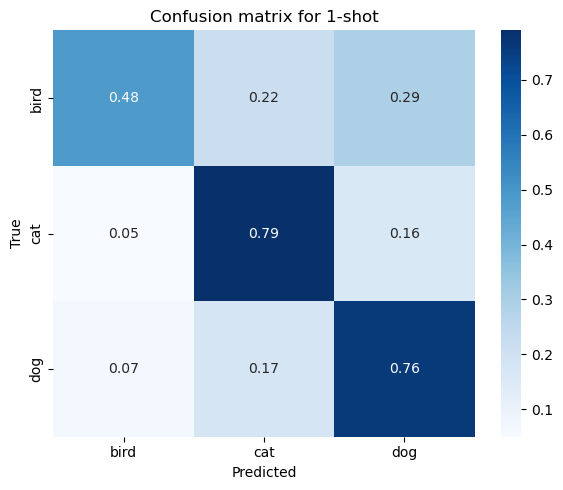


=== Evaluation metrics ===
accuracy    : 0.6783
f1_macro    : 0.6719
precision_macro: 0.7002
recall_macro: 0.6783


/Users/ilan/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


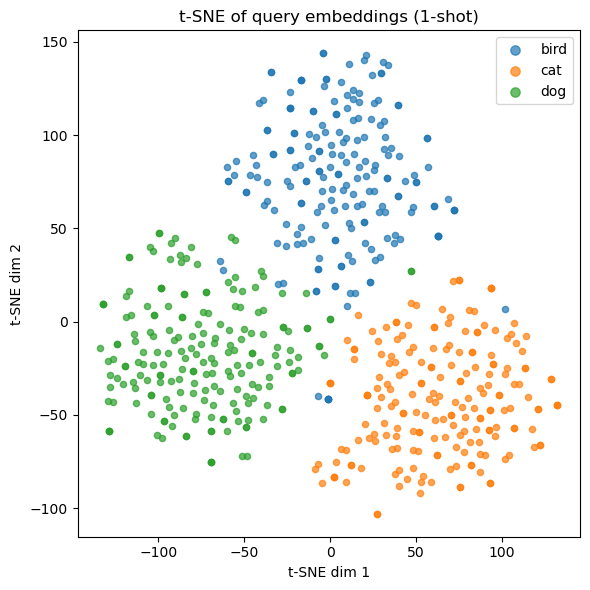


--- 5-shot ---
Accuracy : 0.8767 ± 0.0949
F1 macro : 0.8761


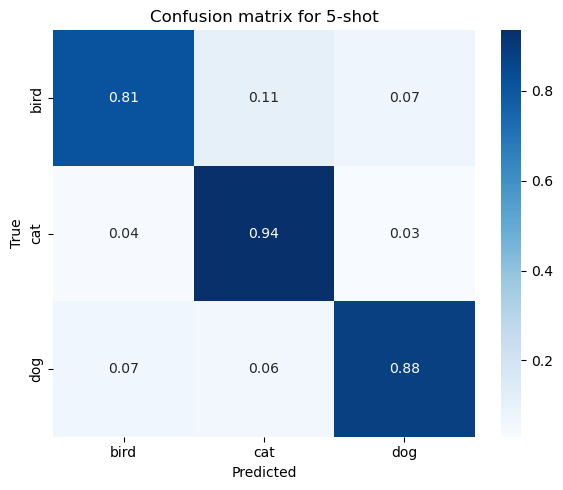


=== Evaluation metrics ===
accuracy    : 0.8767
f1_macro    : 0.8761
precision_macro: 0.8780
recall_macro: 0.8767


/Users/ilan/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


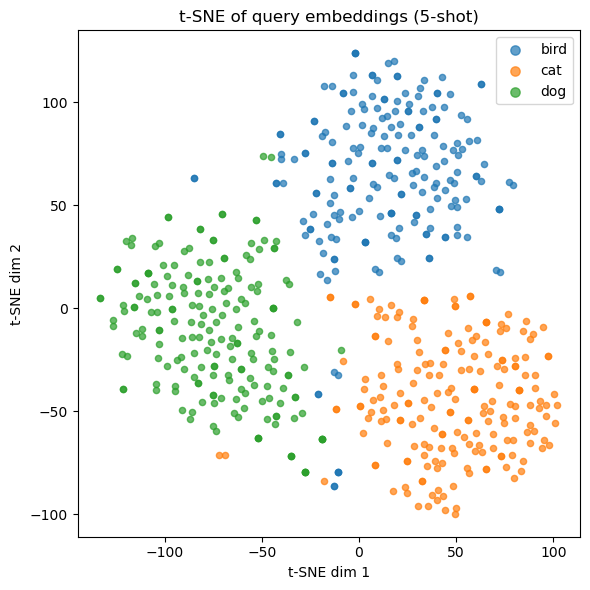


--- 10-shot ---
Accuracy : 0.9467 ± 0.0267
F1 macro : 0.9465


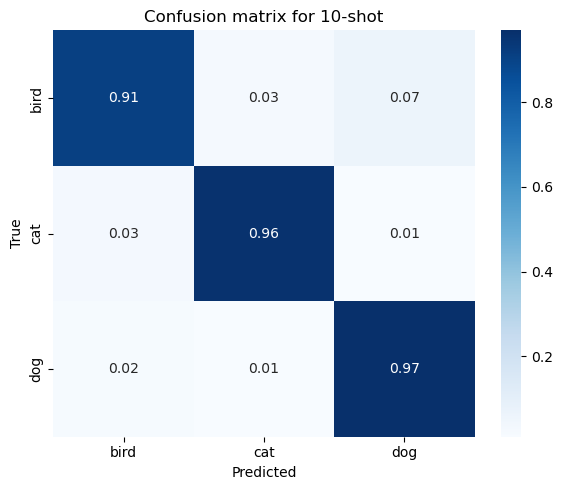


=== Evaluation metrics ===
accuracy    : 0.9467
f1_macro    : 0.9465
precision_macro: 0.9470
recall_macro: 0.9467


/Users/ilan/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


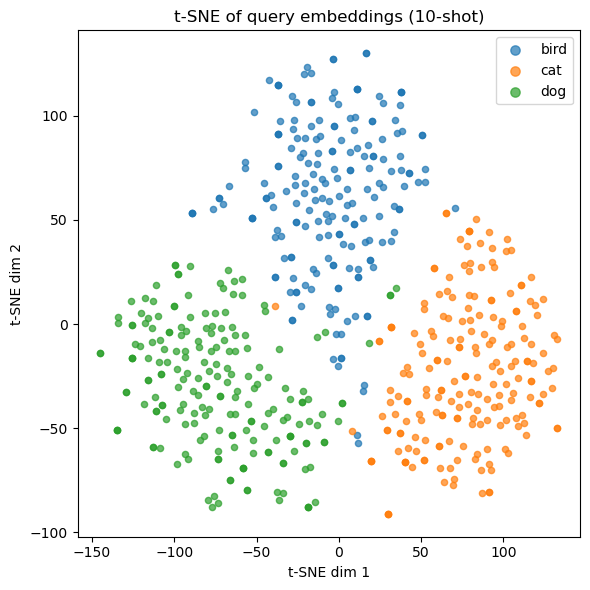

In [20]:
evaluate_benchmark(results, class_names=dataset.classes)